# Kredi Risk Değerlendirme 

Yeh ve Lien (2009) tarafından kredi riskini değerlendirmek amacıyla kullanılan bir veri setini kullanacağız. Veri setinde eksik değerler veri setine benim tarafından yerleştirildi. Orijinal veri setini linkten indirebilirsiniz: http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Etiketli bir veri setiyle çalışacağımız için güdümlü öğrenme tekniklerinden yararlanacağız.

## Neler yapacağız?

* Güdümlü öğrenme kullanarak ve müşterilerin 6 aylık örüntülerine bakarak kredi ödemesinde sıkıntı olacak müşterileri tahmin edeceğiz.
* Veri setini inceleyerek yeni öznitelikler türeteceğiz.
* Kullandığımız yöntemlerin başarısını inceleyeceğiz.

Veri setini (train, test) okutarak başlayalım

In [1]:
#Paketleri yükleyelim
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Veri setlerini okutalım ve inceleyelim
df_train = pd.read_excel('Credit_Scoring_train.xls')
df_test = pd.read_excel('Credit_Scoring_test.xls')

print(df_train.head())

for i in df_train.columns:
    print(i)

    CUSTOMER_ID  LIMIT_BAL     SEX   EDUCATION MARRIAGE   AGE  PAYMENT_1  \
0  461090387729    10000.0    Male         NaN  Married  43.0         -1   
1  456333788060    10000.0  Female         NaN   Single  24.0         -1   
2  530658128376    10000.0  Female         NaN   Single  21.0          0   
3  546506894510    10000.0    Male         NaN   Single  35.0          3   
4  469501329931    10000.0    Male  Gradschool   Single  47.0          0   

   PAYMENT_2  PAYMENT_3  PAYMENT_4   ...     REMAINING_AMOUNT_4  \
0          0          0          0   ...                      0   
1          0          0          0   ...                   2583   
2          0          0          0   ...                   8099   
3          2          0          0   ...                   8838   
4          0          0         -1   ...                   2640   

   REMAINING_AMOUNT_5  REMAINING_AMOUNT_6  PAYMENT_AMOUNT_1  PAYMENT_AMOUNT_2  \
0                   0                   0              2537

## Veri Sözlüğü

Veride aşağıdaki kolonlar yer almaktadır:

* CUSTOMER_ID: Müşteriye özel ID.
* LIMIT_BAL: Kredi limiti.
* SEX: Cinsiyet (Male, Female). 
* EDUCATION: Eğitim (Gradschool, University, Highschool). 
* MARRIAGE: Medeni durum (Married, Single). 
* AGE: Yaş (year). 
* PAYMENT_1 - PAYMENT_6: Ay bazında geçmiş ödemelerdeki gecikme (1 - Eylül 2005, 6 - Nisan 2005 olacak şekilde).
* REMAINING_AMOUNT_1 - REMAINING_AMOUNT_6: Kalan borç miktarı (1 - Eylül 2005, 6 - Nisan 2005 olacak şekilde).
* PAYMENT_AMOUNT_1 - PAYMENT_AMOUNT_6: Önceki ödemeler (1 - Eylül 2005, 6 - Nisan 2005 olacak şekilde).
* default: Çıktı değeri, borcun zamanında ödenip ödenmediği (0 = Zamanında, 1 = Geç)


Önce sayısal kolonlara bakarak eksik değer olup olmadığına bakalım.

In [2]:
print(np.shape(df_train))

print(df_train['LIMIT_BAL'].describe())
print(df_train['AGE'].describe())
print(df_train[[i for i in df_train.columns if 'REMAINING_AMOUNT' in i]].describe())
print(df_train[[i for i in df_train.columns if 'PAYMENT' in i]].describe())


(19800, 25)
count      19797.000000
mean      167964.220842
std       129539.225759
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64
count    19781.000000
mean        35.540064
std          9.220722
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64
       REMAINING_AMOUNT_1  REMAINING_AMOUNT_2  REMAINING_AMOUNT_3  \
count        19800.000000        19800.000000        1.980000e+04   
mean         51265.968131        49428.558232        4.719719e+04   
std          73465.137845        71323.105122        6.942574e+04   
min        -165580.000000       -33350.000000       -1.572640e+05   
25%           3605.750000         3066.250000        2.694750e+03   
50%          22357.500000        21394.000000        2.010050e+04   
75%          66868.750000        64229.500000        6.039650e+04   
max       

Kredi limiti ve yaş kolonlarında eksik değerler oldğunu görüyoruz. Bu gözlemleri analizden çıkarabilir ya da eksik değerleri kendimiz doldurabiliriz. Burada hangisini tercih edeceğimiz eksik gözlem sayısı ve özniteliğin önemine göre değişebilir. 

Yaş için bir değer kullanarak eksikleri giderelim. bunun için ortalama ya da median değeri kullanılabilir. Kredi limiti için de öneminden dolayı bu kolonu eksik olan müşterileri analizden çıkaralım

Eksik değerleri doldurmak için scikit-learn'deki **Imputer** fonksiyonunu kullanalım.

In [3]:
# LIMIT_BAL değeri boş olan kolonları siliyoruz
df_train = df_train[df_train['LIMIT_BAL'] >0]

print(np.shape(df_train))

#AGE kolonunu median değeriyle dolduruyoruz. Missing değer ve strategy (nasıl dolduracağımız) bilgisini verelim.
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median')
df_train['AGE'] = imp.fit_transform(df_train['AGE'].reshape(-1,1)).ravel()

print(np.shape(df_train))
print(df_train['AGE'].describe())
print(df_train['LIMIT_BAL'].describe())


(19797, 25)
(19797, 25)
count    19797.000000
mean        35.539375
std          9.216861
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64
count      19797.000000
mean      167964.220842
std       129539.225759
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64


C:\Users\byuceoglu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


Şimdi de kategorik değişkenler içeren kolonları inceleyelim.

In [4]:
print(df_train['SEX'].describe())
print(df_train['EDUCATION'].describe())
print(df_train['MARRIAGE'].describe())

count      19797
unique         2
top       Female
freq       11962
Name: SEX, dtype: object
count          19517
unique             3
top       University
freq            9235
Name: EDUCATION, dtype: object
count      19555
unique         2
top       Single
freq       10570
Name: MARRIAGE, dtype: object


Eğitim ve medeni durumla ilgili kolonlarda eksik değerler var. Müşterinin finansal durumuyla ilgili bilgi içerebileceği için ve eksik değerlere sahip müşteri sayısı fazla olduğu için bu kolonların değerlerinin eksik olduğunu belirtelim.

Bunu yapmak için eksik değerli kolonları 'MISSING' anahtar kelimesiyle belirtelim. 

In [5]:
#Boş olan değerleri istediğimiz değerle doldurmanın bir diğer yolu da fillna kullanmak
df_train['EDUCATION'].fillna('MISSING_EDU', inplace = True)
df_train['MARRIAGE'].fillna('MISSING_MAR', inplace = True)

print(df_train['EDUCATION'].head())

0    MISSING_EDU
1    MISSING_EDU
2    MISSING_EDU
3    MISSING_EDU
4     Gradschool
Name: EDUCATION, dtype: object


Artık her müşterinin medeni durumu Single, Married, MISSING_MAR değerlerinden birine sahip. Ancak bu kolonu hala tahmin için kullanmamaız mümkün değil. Bunu yapmak için kolonu nümerik değerlere çevirmemiz gerekiyor. Burada sıklıkla yapılabilen bir hata her bir durum için bir sayı atamaktır (0 = married, 1 = single, 2 = MISSING_MAR gibi). Bunun yerine takma değişkenler (dummy variable) kullanabiliriz. Her bir değer için ayrı bir kolon oluşturulup ikili değerlerle gözlemlerin ait olduğu değer belirtilir. bu amaçla pandas altında **get_dummies** fonksiyonunu kullanabiliriz. 

In [6]:
df_education = df_train[ 'EDUCATION' ]
print(df_education.head())
df_education = pd.get_dummies(df_education)

print(df_education.head())

df_marriage = df_train[ 'MARRIAGE' ]
print(df_marriage.head())
df_marriage = pd.get_dummies(df_marriage)

print(df_marriage.head())

0    MISSING_EDU
1    MISSING_EDU
2    MISSING_EDU
3    MISSING_EDU
4     Gradschool
Name: EDUCATION, dtype: object
   Gradschool  Highschool  MISSING_EDU  University
0           0           0            1           0
1           0           0            1           0
2           0           0            1           0
3           0           0            1           0
4           1           0            0           0
0    Married
1     Single
2     Single
3     Single
4     Single
Name: MARRIAGE, dtype: object
   MISSING_MAR  Married  Single
0            0        1       0
1            0        0       1
2            0        0       1
3            0        0       1
4            0        0       1


Artık yapmamız gereken bütün bu yaptıklarımı bir araya getirip train ve test veri setlerini oluşturmak. Bu amaçla ID, EDUCATION, MARRIAGE kolonlarını çıkararak yeni oluşturduğumuz veri çerçeveleriyle önceki ver çerçevesini birleştireceğiz.

In [7]:
#Kullanmayacağımız kolonları siliyoruz
df_train.drop(['CUSTOMER_ID', 'EDUCATION', 'MARRIAGE'] , axis=1, inplace=True)

#Veri çerçevelerini birleştiriyoruz
df_train = pd.concat([df_train, df_education, df_marriage], axis=1)

print(df_train.head())

   LIMIT_BAL     SEX   AGE  PAYMENT_1  PAYMENT_2  PAYMENT_3  PAYMENT_4  \
0    10000.0    Male  43.0         -1          0          0          0   
1    10000.0  Female  24.0         -1          0          0          0   
2    10000.0  Female  21.0          0          0          0          0   
3    10000.0    Male  35.0          3          2          0          0   
4    10000.0    Male  47.0          0          0          0         -1   

   PAYMENT_5  PAYMENT_6  REMAINING_AMOUNT_1   ...    PAYMENT_AMOUNT_5  \
0         -1         -1               17560   ...                   0   
1          0         -1                5742   ...                   0   
2          0         -1                7691   ...                   0   
3          0         -1               10281   ...                   0   
4         -1         -1                7968   ...                 738   

   PAYMENT_AMOUNT_6  default  Gradschool  Highschool  MISSING_EDU  University  \
0                 0        1       

Aynı şeyi SEX kolonu için de yapalım.

In [8]:
#Kategorik değişkenleri dummye çevirmenin bir başka yolu
df_train['MALE'] = (df_train.SEX == 'Male')*1
df_train['FEMALE'] = (df_train.SEX == 'Female')*1
df_train.drop('SEX', axis=1, inplace=True)

Son olarak yeni öznitelikler türetelim. 

* Müşterilerin kredi limitleri oldukça önemli bir bilgi gibi duruyor. Büyük olasılıkla yaşlandıkça limitiniz de artacak.  'LIMIT_PER_AGE' adlı bir kolonla limiti yaşa bölerek yeni bir değişken oluşturalım. Bu sayede aynı limite sahip iki müşteriden daha genç olanını ayırdedebileceğimiz bir değişken oluşturuyoruz. Genç ve yüksek limitli bir müşteri daha cazip bir müşteri olabilir.
* Aynı zamanda bankaya olan borcunuzla maddi durumunuzun da ilişkisini kurmak yararlı olabilir. Aynı borca sahip iki müşteriden limiti daha yüksek olan daha az riskli bir müşteri olabilir. REMAINING_AMOUNT_1 kolonunu LIMIT_BAL kolununa bölerek yeni bir değişken türetelim.

In [9]:
#Yeni değişkenler oluşturuyoruz.
df_train['LIMIT_PER_AGE'] = df_train['LIMIT_BAL'] / df_train['AGE']
df_train['RELATIVE_REMAINING_AMOUNT'] = df_train['REMAINING_AMOUNT_1'] / df_train['LIMIT_BAL']


Aynı adımları test verisi için de yapalım.

In [10]:
df_test = pd.read_excel('Credit_Scoring_test.xls')
df_test['AGE'] = imp.transform(df_test['AGE'].reshape(-1, 1)).ravel()

df_test['EDUCATION'].fillna('MISSING_EDU', inplace = True)
df_test['MARRIAGE'].fillna('MISSING_MAR', inplace = True)

df_education = df_test[ 'EDUCATION' ]
df_education = pd.get_dummies(df_education)

df_marriage = df_test[ 'MARRIAGE' ]
df_marriage = pd.get_dummies(df_marriage)

df_test.drop(['CUSTOMER_ID', 'EDUCATION', 'MARRIAGE'] , axis=1, inplace=True)

df_test = pd.concat([df_test, df_education, df_marriage], axis=1)

df_test['LIMIT_PER_AGE'] = df_test['LIMIT_BAL'] / df_test['AGE']
df_test['RELATIVE_REMAINING_AMOUNT'] = df_test['REMAINING_AMOUNT_1'] / df_test['LIMIT_BAL']

df_test['MALE'] = (df_test.SEX == 'Male')*1
df_test['FEMALE'] = (df_test.SEX == 'Female')*1
df_test.drop('SEX', axis=1, inplace=True)

df_test = df_test[df_train.columns]

C:\Users\byuceoglu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


# Sınıflandırma ve Değerlendirme

Bu aşamada gradient boosting yöntemini kullanacağız (sklearn.ensemble.GradientBoostingClassifier).

In [11]:
#Hedef değişkenleri (default adlı kolon) veri çerçevesinden ayırıyoruz.
y_train = df_train.default
y_test = df_test.default

df_train.drop('default', axis=1, inplace=True)
df_test.drop('default', axis=1, inplace=True)

Şu an için modelin parametreleriyle oynamıyoruz. Şimdi modeli kuralım.

In [12]:
#Modeli kurup eğitiyoruz
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(df_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Sonuçları değerlendirelim.

In [13]:
# Modeli değerlendirelim. Bunun için doğruluk ve eğri altı alana bakalım

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

print('Gradient Boosting')
print('Accuracy')
print(accuracy_score(y_test, gbc.predict(df_test)))
print('AUC score')
print(roc_auc_score(y_test, gbc.predict_proba(df_test)[:,1]))
print('Confusion Matrix')
print(confusion_matrix(y_test, gbc.predict(df_test)))

Gradient Boosting
Accuracy
0.817549019608
AUC score
0.776660048042
Confusion Matrix
[[7488  413]
 [1448  851]]


Eğri altı alanı görselleştirelim. Kredisini ödeyemeyecek müşterilerin %80'ini tahmin etmek istersek ödeyecek müşteriler için ne kadarlık bir hata payımız oluyor?

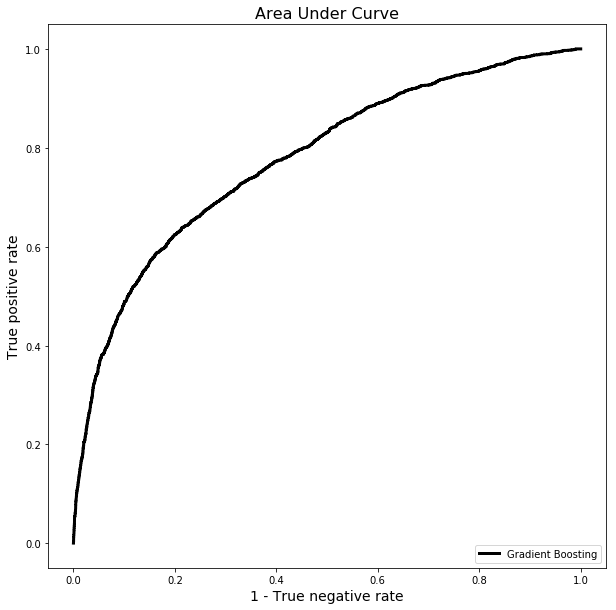

In [14]:
a_gbc , b_gbc, c_gbc = roc_curve(y_test,gbc.predict_proba(df_test)[:,1])

plt.figure(figsize=(10,10))

plt.plot(a_gbc,b_gbc, c='black', label = 'Gradient Boosting', linewidth = 3)
plt.title('Area Under Curve', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 14)
plt.xlabel('1 - True negative rate', fontsize = 14)

plt.legend(loc = 4)
plt.show()

Eğri altı alan true positive rate (borcunu ödeyemeyeceği doğru bilinen müşteri yüzdesi) ile true negative rate (borcunu ödeyeceği doğru bilinen müşteri yüzdesi) arasındaki ilişkiyi gösterir. True positive rate 0 ise true negative rate 1 oluyor (Herkes ödeyecek şeklinde bir tahmine denk geliyor). Diğer uca bakarsak, herkesi ödeyemeyecek şeklinde tahmin ettiğimizde ödeyecek müşterilerin tamamını yanlış sınıflandırmış oluyoruz. Borcunu ödeyemeyecek müşterilerin %75'ini bilmek istersek borcunu ödeyemeyecek müşterilerde %35 civarında yanlış tahmin yapmamız gerekiyor. 

# Fine Tuning

Scikit-learndeki classifier yöntemleri için bir çok parametre seçme opsiyonumuz var. Genelde varsayılan parametreler oldukça başarılı sonuçlar verse de parametrelerle oynamak sonuçları iyileştirebilir. Biz de iterasyon sayısını (n_estimators), modeli oluşturan karar ağaçlarının derinliklerini (**max_depth**) ve yaprak düğümlerindeki en az gözlem sayısını (**min_samples_leaf**) değiştirerek başlayalım. Değerlendirme için eğri altı alan değerini kullanacağız. 

Parametreleri denemek için Grid Search modülünü kullanalım. Bu modülü kullanarak  belirleyelim.

In [15]:
from sklearn.model_selection import GridSearchCV
from time import time 
# Grid search ile denenecek model parametreleri ve değerleri
parameters = {"max_depth": [3, 10],
              "min_samples_leaf": [20, 100],
              "n_estimators": [50]}

# Kullanacağımız model
gbc = GradientBoostingClassifier()

#Grid search modelini oluşturuyoruz
grid_search = GridSearchCV(gbc, param_grid=parameters, cv=2, scoring = 'roc_auc', verbose = 2)
start = time()

#Modeli eğitiyoruz
grid_search.fit(df_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))




GridSearchCV took 19.66 seconds for 4 candidate parameter settings.


C:\Users\byuceoglu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [16]:
print(grid_search.best_estimator_)
print(roc_auc_score(y_test, grid_search.best_estimator_.predict_proba(df_test)[:,1]))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
0.777120509189


# Özniteliklerin Değerlendirilmesi

Gradient Boosting için kullanacağımız parametreleri belirledikten sonra modeli bu parametrelerle kurup önemli öznitelikleri belirleyelim. Bu amaçla **feature\_importances\_** değerlerine bakacağız.

[ 0.00825386  0.01381983  0.26751329  0.02316183  0.04780658  0.03145747
  0.0258506   0.02780256  0.07981321  0.00179866  0.00914522  0.01629145
  0.02429992  0.0053601   0.02725399  0.0439218   0.02285052  0.01851818
  0.02143866  0.03017778  0.00622422  0.00286759  0.04198695  0.00047944
  0.          0.0196989   0.00319961  0.01122611  0.00911225  0.0845904
  0.07407904]
                           Importance
LIMIT_BAL                    0.008254
AGE                          0.013820
PAYMENT_1                    0.267513
PAYMENT_2                    0.023162
PAYMENT_3                    0.047807
PAYMENT_4                    0.031457
PAYMENT_5                    0.025851
PAYMENT_6                    0.027803
REMAINING_AMOUNT_1           0.079813
REMAINING_AMOUNT_2           0.001799
REMAINING_AMOUNT_3           0.009145
REMAINING_AMOUNT_4           0.016291
REMAINING_AMOUNT_5           0.024300
REMAINING_AMOUNT_6           0.005360
PAYMENT_AMOUNT_1             0.027254
PAYMENT_AMOUNT

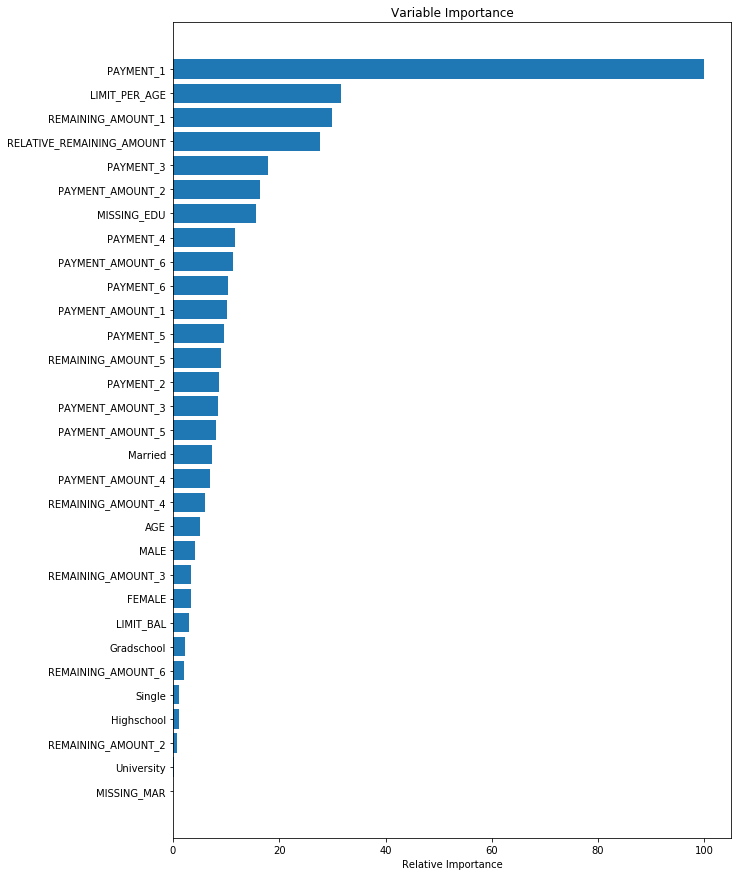

In [17]:
gbc= GradientBoostingClassifier(n_estimators=50, max_depth=3, min_samples_leaf=100)
gbc.fit(df_train, y_train)
# Özniteliklerin önemi
feature_importance = gbc.feature_importances_

print(feature_importance)

df_features = pd.DataFrame(feature_importance)
df_features.columns = ['Importance']
df_features.index = df_train.columns
print(df_features)
# Maximum 100 olacak şekilde ağırlıklandırıyoruz
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


Bizim oluşturduğumuz öznitelikler oldukça yukarılarda çıktı. Eğitim ve cinsiyetle ilgili değişkenler ise genelde alt sıralarda En önemli değişken ise 1 önceki ayın ödemesindeki gecikme. 

# References
Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.